## Liquidation with Permanent Price Impact

### Introduction

The agent controls their speed of trading $\nu$, and assumes that she receives an execution price of
$$
S_t^{\nu} - k\, Q_t^{\nu}
$$
which is linear in her trading rate to account for the cost of walking the limit order book. Furthermore, her trading induces a drift in the asset price, which is otherwise assmed to be a Brownian motion. Hence, $S^{\nu}_t$ satisfies the SDE
$$
dS_t^\nu = a \,\nu_t\,dt + \sigma \, dW_t
$$
She aims to maximize the  performance criterion 
$$
\mathbb{E}\Big[ X_T^{\nu} + Q_T^{\nu}(S_T^{\nu} - \alpha Q_T^{\nu}) - \phi \int_0^T (Q_u^{\nu})^2\, du\Big]
$$
where $X_T^\nu$ is the total cash from trading, and the term $\alpha\,(Q_T^\nu)^2$ represents a penalty on holding terminal inventory (which we will send to infinity to guarantee liquidation).

### Solving DPE

The dynamic programming principle implies that the value function satisfies the $\textbf{HJB}$ equation
\begin{equation}
0 = (\partial_t + \tfrac{1}{2}\sigma^2\partial_{SS})H - \phi q^2 + \sup_{\nu}\{(\nu(S - f(\nu))\partial_x - g(\nu) \partial_S - \nu \partial_q)H\}
\end{equation}

subject to the terminal condition $H(T,x,S,q) = x + Sq - \alpha q^2$.

For the case of linear impact functions $f(\nu)=k\,\nu$ and $g(\nu)=b\,\nu$, the  $\textbf{DPE}$ can be solved explicitly and the optimal speed to trade is
\begin{equation}
\nu_t^* = \gamma \frac{\zeta e^{\gamma(T-t)} + e^{-\gamma(T-t)}}{\zeta e^{\gamma(T-t)} - e^{-\gamma(T-t)}}\, Q_t^{{\nu}^*}
\end{equation}

From this equation, it is also possible to obtain the agent's inventory $Q_t^{\nu^*}$ that results from following this strategy.

\begin{equation}
Q_t^{\nu^*} = \frac{\zeta e^{\gamma(T-t)} + e^{-\gamma(T-t)}}{\zeta e^{\gamma(T-t)} - e^{-\gamma(T-t)}} \,Q_0.
\end{equation}

Now we show the implementation of the optimal speed to trade at and inventory along the optimal strategy in the following code.

In [2]:
# Import necessary libraries
import numpy as np
import import_ipynb
import matplotlib.pyplot as plt

The following code computes the optimal speed to trade at $\nu_t^*$ and inventory along the optimal strategy $Q_t^{\nu^*}$.

In [ ]:
# Parameter settings
T = 1 # 1 day
Ndt = 6.5 * 3600 # 1 day = 6.5 hours = 6.5 * 3600 seconds(1초단위)
dt = T / Ndt
t = np.arange(0, T + dt, dt)

k = 0.001
b = 0.001

tau = T - t
tt = np.arange(0, 1 + 1 / 10, 1 / 10) # time points to be marked(포인트를 찍을 배열)

myphi = np.array([10e-10, 0.001, 0.01, 0.1])
symb = np.array(["o", "*", "+", "^"])

alpha = 100

1. inter_extrapolation(x, y, e) 함수 설명
    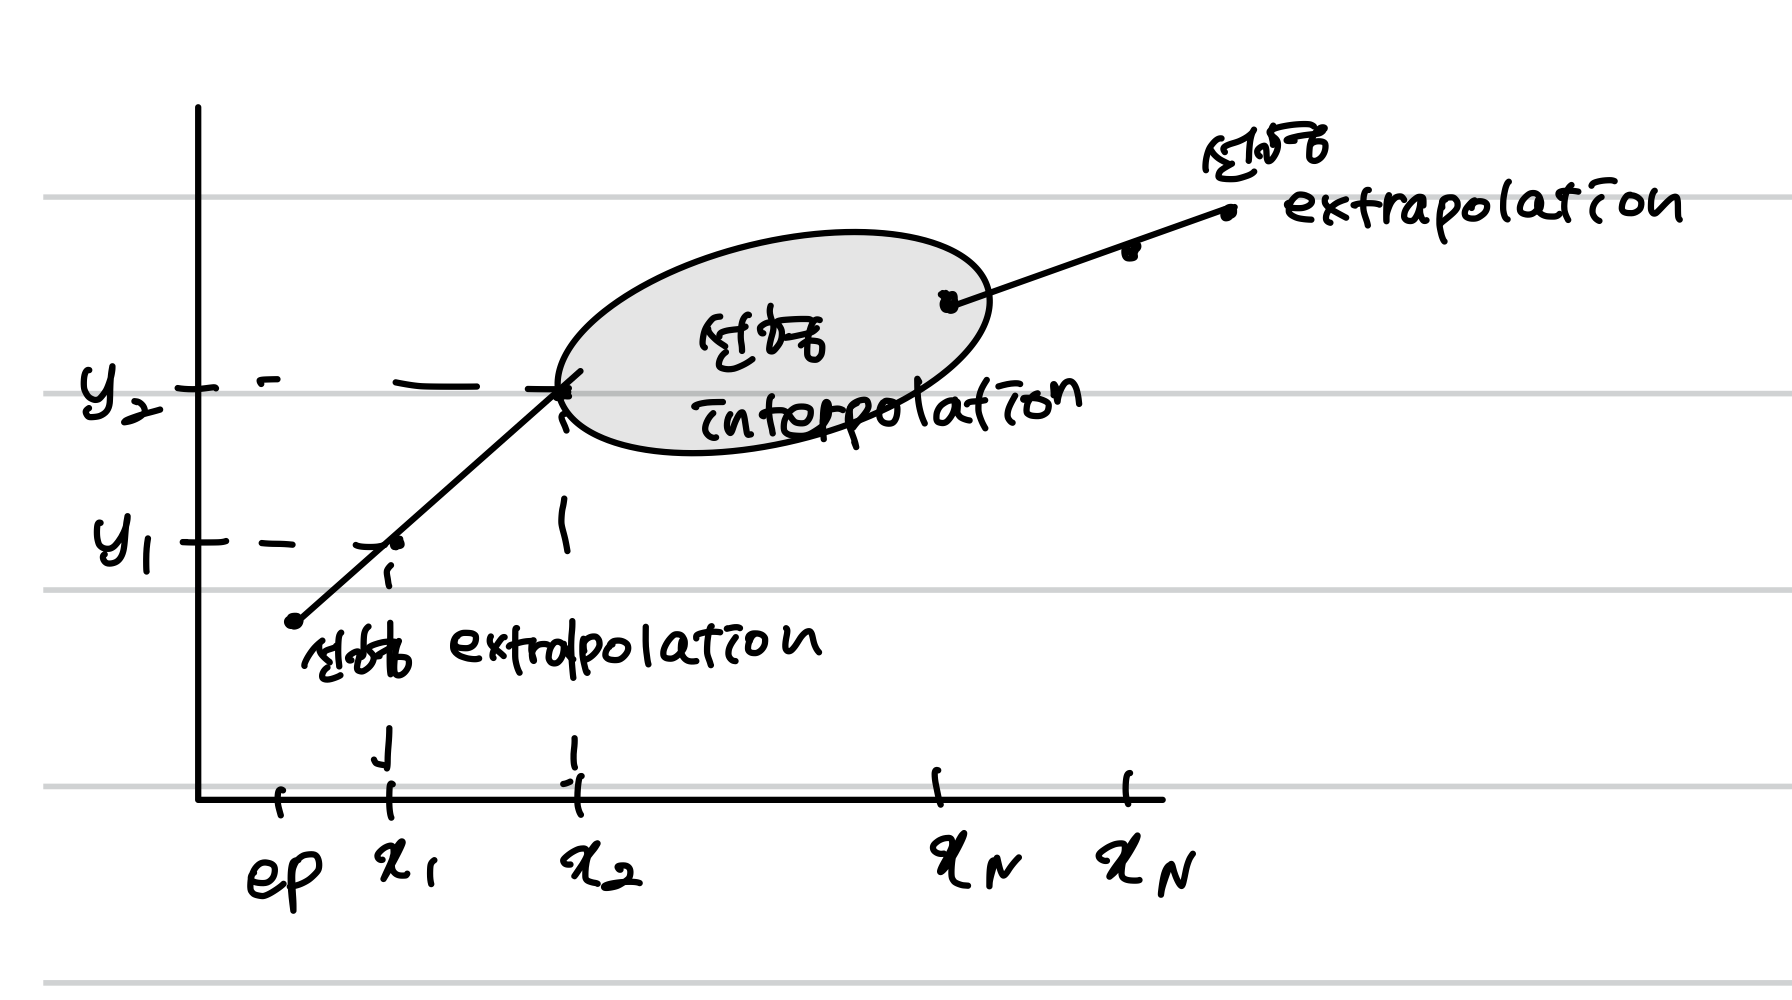

In [16]:
# Functions
def inter_extrapolation(x, y, e):
    """ Extrapolation and interpolation.
        (x_1,y_1) ... (x_N,y_N) -> x_1 ~ x_N 사이의 임의의 e에 대해 y값을 계산(extrapolation or interpolation)
    :param x: a numpy array
    :param y: a numpy array
    :param e: a numpy array, equivalent of x
    :return: a numpy array
    """
    new_x = np.sort(x)
    new_y = y[np.argsort(x)]

    def point_wise(ep):
        if ep < new_x[0]: # point가 x_1보다 작을 때
            return new_y[0] + (ep - new_x[0]) * (new_y[1] - new_y[0]) / (new_x[1] - new_x[0]) # linear extrapolation
        if ep > new_x[-1]: # point가 x_N보다 클 때
            return new_y[-1] + (ep - new_x[-1]) * (new_y[-1] - new_y[-2]) / (new_x[-1] - new_x[-2]) # linear extrapolation
        else:
            return np.interp([ep], new_x, new_y)[0] # linear interpolation
    return np.array([point_wise(ep) for ep in e])

def calculate_inventory_trading_speed(alpha, phi, t, tt, T, b, k):
    """ 이게 핵심!
        For given points t, this function solve for the optimal speed of trading as nu, and investor's inventory along the
        optimal path as Q. 
        This function also returns optimal speed of trading as nut, and investor's inventory along the optimal path Qt as a
        function of time, tt, which is a vector of time points to be marked.
    """
    tau = T - t
    zeta = ((alpha-0.5*b) + np.sqrt(k*phi)) / ((alpha - 0.5*b) - np.sqrt(k*phi))
    gamma = np.sqrt(phi/k)
    chi= np.sqrt(k*phi) * np.divide((1+zeta*np.exp(2*gamma*tau)),(1-zeta*np.exp(2*gamma*tau)))
    Q = np.divide(zeta*np.exp(gamma*tau)-np.exp(-gamma*tau),zeta*np.exp(gamma*T)-np.exp(-gamma*T))
    nu = np.multiply(-chi,Q)/k
    Qt = inter_extrapolation(t,Q,tt)
    nut = inter_extrapolation(t,nu,tt)
    return  Q, nu, Qt, nut


def plot_inventory_trading_speed(alpha0, phi, symb, t, tt, T, b, k, labels, main):
    """ This function plots the optimal inventory & trading speed paths using above function
        to calculate inventory and speed of tading vs time.
    """
    fig, (ax_inv,ax_trad) = plt.subplots(ncols=2)
    fig.set_size_inches(10.5,5.5)
    color_idx = np.linspace(0, 1, phi.shape[0])
    for i,line in zip(color_idx,range(0,phi.shape[0])):
        inv_line, trad_line, inv_dot, trad_dot = calculate_inventory_trading_speed(alpha0, phi[line], t, tt, T, b, k)
        plt1, = ax_inv.plot(tt, inv_dot, color=plt.cm.rainbow(i),label = labels[line],marker = symb[line],linestyle = 'None')
        plt2, = ax_trad.plot(tt, trad_dot, color=plt.cm.rainbow(i),label = labels[line],marker = symb[line],linestyle = 'None')
        plt3, = ax_inv.plot(t, inv_line, linestyle='-',color=plt.cm.rainbow(i))
        plt4, = ax_trad.plot(t, trad_line, linestyle='-',color=plt.cm.rainbow(i))
    ax_inv.legend()
    ax_inv.set_xlabel(r'Time', fontsize=18)
    ax_inv.set_ylabel(r'Inventory', fontsize=18)
    ax_trad.legend()
    ax_trad.set_xlabel(r'Time', fontsize=18)
    ax_trad.set_ylabel(r'Trading Speed', fontsize=18)
    ax_trad.yaxis.set_label_coords(-0.1,0.5)
    plt.suptitle(main, fontsize=20)
    fig.canvas.draw()

Now we use show the change of the investor's inventory along the optimal path for various levels of the running penalty $\phi$ as $\alpha$ changes.

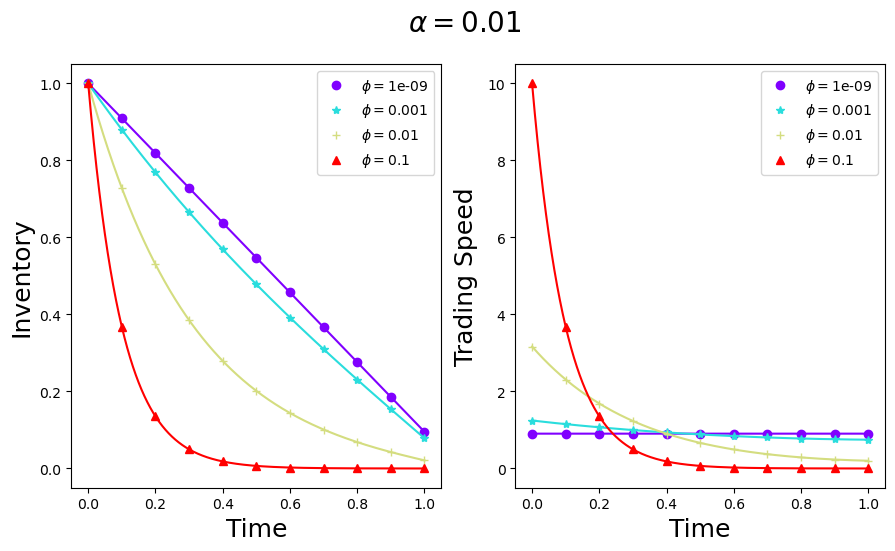

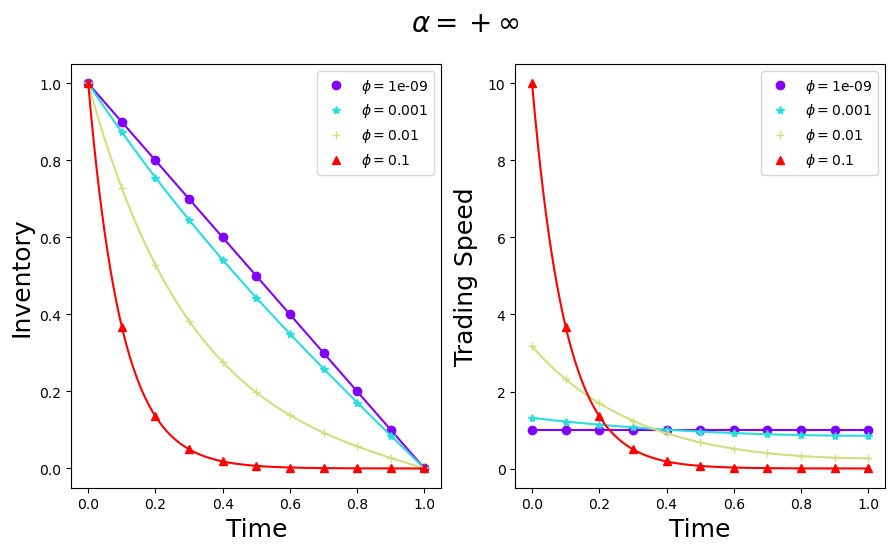

In [17]:
# Plot figures
plot_inventory_trading_speed(0.01, myphi, symb, t, tt, T, b, k, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = 0.01$")
plot_inventory_trading_speed(100, myphi, symb, t, tt, T, b, k, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = +\infty$")

1. 재고 패널티가 커질 수록 -> 더 빨리 팔려고 한다 -> trading speed가 초반에 빠르다.(빨간색)
2. alpha 가 finite하면 -> 마지막에 남는다